Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, September 16, 2016.

### Import relevant packages

In [1]:
%matplotlib inline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as op
import scipy as sp
import sympy as sy
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_context('notebook')
from mpl_toolkits.basemap import Basemap
import os, sys, re
from glob import glob
from string import *
from datetime import datetime
from dateutil.parser import parse

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

numpy.ndarray

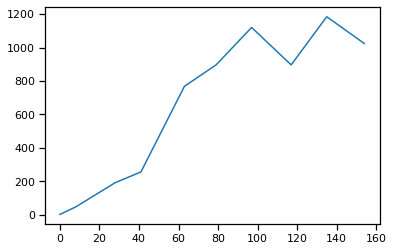

In [2]:
days = np.transpose([0,8,28,41,63,79,97,117,135,154])
beetles = np.transpose([2,47,192,256,768,896,1120,896,1184,1024])

plt.plot(days, beetles)
type(days)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

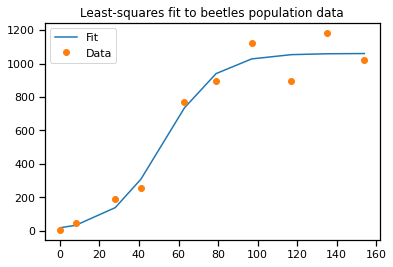

[1.78671441e+01 1.06006004e+03 7.74710938e-02]

Standard Error =   77.07325 
r =    0.98447


(array([1.78671441e+01, 1.06006004e+03, 7.74710938e-02]), 1)

In [3]:
def residuals(p, y, t):
    No, K, r = p
    err = y - K*No/(No+(K-No)*np.exp(-r*t))
    return err

def peval(t, p):
     return p[0]*p[1]/(p[0]+(p[1]-p[0])*np.exp(-p[2]*t))

p0 = np.array([2,1000,0.1])
args= (beetles,days)
plsq = op.leastsq(residuals, p0, args=(beetles, days))

N = np.shape(beetles)[0]
standard_error = np.sqrt(np.power((beetles-peval(days, plsq[0])),2).sum()/N)
standard_error

SSE = np.power((beetles-peval(days, plsq[0] )),2).sum()

SST = np.power(beetles-beetles.mean(),2).sum()

r = np.sqrt(1-SSE/SST)



plt.plot(days, peval(days, plsq[0]),days,beetles,'o')
plt.title('Least-squares fit to beetles population data')
plt.legend(['Fit', 'Data'],loc=0) 
plt.show()

print(plsq[0])

print("\nStandard Error = %10.5f \nr = %10.5f" %(standard_error,r)) 
plsq

Before we set out to solve this equation let us first derive the maximum likelihood function and its corresponding log-likelihood. Since we are to assume that the $\log{y_i}$ are normally distributed we may take it as a given that the set of $\log{y_i}$ come from a the normal distribution $~N(\mu,\sigma)$ with probability density function $f(x_i,\theta)$, where $x_i = \ln{y_i}$.

$\Large{f(x_i,\theta) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}}$

The likelihood function is the product of all $f(x_i,\theta)$:

$\Large{L(\vec{\mathbf{\theta}})  = f(y_1;\theta)f(y_2;\theta)\cdots f(y_n;\theta)}$.

$\Large{L(\vec{\mathbf{\theta}})  = \prod_{i=1}^n f(y_i|\theta)}$ 

Substituting for the PDF of the normal distribution we have:

$\Large{L(\vec{\mathbf{\theta}})  = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} \Large{e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}}}$

For numerical stability it is more useful to work with the log-likelihood. Which is simply the log of the likelihood function:

$\Large{l(\vec{\mathbf{\theta}})  = \ln{(\prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\Large{-\frac{(x_i-\mu)^2}{2\sigma^2}}})}}$

Simplification via algebra provides the following:

$\Large{l(\vec{\mathbf{\theta}})  = \sum_{i=1}^n \ln{(\frac{1}{\sqrt{2 \pi \sigma^2}} e^{\Large{-\frac{(x_i-\mu)^2}{2\sigma^2}}})}}$

$\Large{l(\vec{\mathbf{\theta}})  = \sum_{i=1}^n \ln(\frac{1}{\sqrt{2 \pi \sigma^2}})+ \sum_{i=1}^n \ln(e^{\Large{-\frac{(x_i-\mu)^2}{2\sigma^2}}})}$

$\Large{l(\vec{\mathbf{\theta}})  = -n\ln(\sqrt{2 \pi \sigma^2})+ \sum_{i=1}^n -\frac{(x_i-\mu_i)^2}{2\sigma^2}}$

We now have a simplified form of the log-likelyhood which we can subsitute in the values of the $f(x_i,\theta)$ and $x_i$:

$\Large{\text{Here } x_i  = \ln(y_i) \text{ and } \mu_i = \ln\left(\frac{KN_0}{N_0+(K-N_0)e^{-rt_i}}\right)}$

Hence the log-likelihood may be written as follows:

$\Large{l(K,r,\sigma)  = -n\ln(\sqrt{2 \pi \sigma^2})- \sum_{i=1}^n\frac{\left(\ln(y_i)-\ln\left(\frac{KN_0}{N_0+(K-N_0)e^{-rt_i}}\right)\right)^2}{2\sigma^2}}$

It can also be shown the the log-likelihood of such a distribution has the following 1st derivatives:

$\Large{l^\prime(K)  = -\sum_{i=1}^n\frac{\left(\ln(y_i)-\ln\left(\frac{KN_0}{N_0+(K-N_0)e^{-rt_i}}\right)\right)}{\sigma^2}\frac{N_0(1-e^{-rt})}{K(N_0+(K-N_0)e^{-rt})}}$

$\Large{l^\prime(r)  = -\sum_{i=1}^n\frac{\left(\ln(y_i)-\ln\left(\frac{KN_0}{N_0+(K-N_0)e^{-rt_i}}\right)\right)}{\sigma^2}\frac{tKN_0e^{-rt}}{(N_0+(K-N_0)e^{-rt})^2}}$


It can be seen by inspection that when setting the score function $l^\prime(\theta_j) = 0$ only the residual of the logs provides meaningful roots that maximize the log-likelyhood $l(\vec{\mathbf{\theta}})$. That is to say that the likelyhood function is maximized only when:

$\Large{\left(\ln(y_i)-\ln\left(\frac{KN_0}{N_0+(K-N_0)e^{-rt_i}}\right)\right)^2 = 0}$

Thus we must find the roots of the parameters $\theta_j = K,r$ for this objective function by using a multivariate
optimization method. This is clear since we cannot find a solution that reduce the derivative in terms of only one 
parameter.





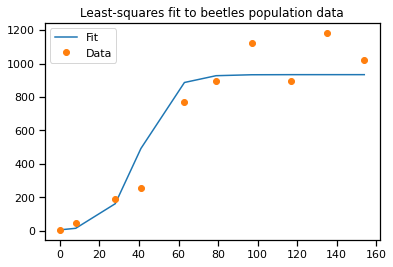


Standard Error =  134.25255 
r =    0.95211


array([9.33397717e+02, 1.28631646e-01, 5.30499709e+00, 1.69768575e+00])

In [4]:
tt=days 
yy=beetles 


objective_logistic = lambda  p,u,m: (np.log(np.sqrt(2*np.pi*p[3]**2)).sum() + 
                                     (np.power((np.log(u)-np.log(p[2]*p[0])+
                                                np.log(p[2]+(p[0]-p[2])*np.exp(-p[1]*m))),2)/(2*p[3]**2)).sum())


x0 = np.array([1.06006004e+03, 7.74710938e-02,1.78671441e+01, 10e+00])
nm_output = op.fmin(objective_logistic, x0, args=(yy,tt),xtol=1e-17, ftol=1e-17)


def peval2(t, p):
     return p[2]*p[0]/(p[2]+(p[0]-p[2])*np.exp(-p[1]*t))
    


plt.plot(days, peval2(days, nm_output),days,beetles,'o')
plt.title('Least-squares fit to beetles population data')
plt.legend(['Fit', 'Data'],loc=0) 
plt.show()

N = np.shape(beetles)[0]
standard_error = np.sqrt(np.power((yy-peval2(days, nm_output)),2).sum()/N)
standard_error


SSE = np.power((yy-peval2(days, nm_output)),2).sum()
SST = np.power(beetles-beetles.mean(),2).sum()
r = np.sqrt(1-SSE/SST)

print("\nStandard Error = %10.5f \nr = %10.5f" %(standard_error,r))

nm_output

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



In [7]:
2.1.a This cell defines the simulated annealing function and related functions and initialzations
baseball = pd.read_table('../data/textbook/baseball.dat', sep='\s+')
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

#Define cooling schedule function
def cooling_schedule(size,tau_start=10,option=0):
    #option 0 offers a smooth rapid exponential decay
    if option == 0:
        return [tau_start*0.9**j for j in range(0,size)]
    #option 1 offers a gradual exponential decay
    if option == 1:
        return [0.9**j/(1+tau_start*0.9**j) for j in range(0,size)]
    #option 2 is a step function
    if option == 2:
        return ([tau_start]*int(size/6) + [tau_start/2]*int(size/5) + 
                [tau_start/10]*int(size/4) + [tau_start/100]*int(7*size/17))

aic_best = []
aic_values = []

def simulated_annealing(tau_start,size,option,neighborhood,ncols):
    
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    aic_best = aic(g, solution_vars, logsalary)
    aic_values.append(aic_best)
    
    cool_schedule = cooling_schedule(size,tau_start,option)
    for tau in cool_schedule:
        
        # Random change size-neighborhood
        flip = np.random.choice(ncols, size=neighborhood, replace=False, p=None) 
        for i in flip:
            solution_current[i] = not solution_current[i]
        solution_vars = predictors[predictors.columns[solution_current]]
        g = LinearRegression().fit(X=solution_vars, y=logsalary)
        aic_step = aic(g, solution_vars, logsalary)
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))

        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                solution_best = solution_current.copy()
        else:
            # Revert solution
            for i in flip:
                solution_current[i] = not solution_current[i]
            aic_values.append(aic_values[-1])
    
    return [solution_best, aic_best,aic_values]



def test_for_temp(option,iterator,tau_start,size=500,neighborhood=1):

    aic_values = []
    aic_best = []
    solution_best = []
    AICt_best_mean = []
    AICt_best_sd = [] 
    AICt_best_min = []
    aic_values = []
    aic_best = []
    solution_best_tot = []
    tau_0 = []
    AICt_best = 10000000000000
    AIC_best_tot = []
    tau_tot = []  
    
    for j in range(0,iterator):
        for i in tau_start:
            [solution_best, aic_best, aic_values] = simulated_annealing(i,size,option,neighborhood,ncols) 
        
            if AICt_best > aic_best:
                AICt_best = aic_best
                tau_0 = i
     
        AIC_best_tot.append(AICt_best)
        tau_tot.append(tau_0)
        solution_best_tot.append(solution_best)

    AICt_best_min = np.min(np.array(AIC_best_tot))
    AICt_best_mean = np.array(AIC_best_tot).mean()
    AICt_best_sd = np.array(AIC_best_tot).std()
    tau_mean = np.array(tau_tot).mean()
    tau_sd = np.array(tau_tot).std()

        
    fig = plt.figure(figsize=(18, 12), dpi=100)
    plt.plot(aic_values)
    plt.xlim(0, len(aic_values))
    plt.xlabel('Iteration')
    plt.ylabel('AIC')
    print('min AIC (mean, sd): {0} ({1})\nmin AIC across simulations: {2}\nTau (mean, sd): {3}({4})\n \
                Best solution: {5}\nDiscovered at iteration {6}'.format(
                AICt_best_mean,
                AICt_best_sd, 
                AICt_best_min,
                tau_mean,
                tau_sd,
                np.where(solution_best==True),
                np.where(aic_values==AICt_best_min)[0][0]))
    plt.plot(np.where(aic_values==AICt_best_min)[0][0], AICt_best_min, 'ro')
    
    return [AICt_best_mean, AICt_best_sd, AICt_best_min, tau_mean, tau_sd]

def test_for_hood(option,iterator=3,tau_start=1,size=3,neighborhood=1):
    
    aic_values = []
    aic_best = []
    solution_best = []
    AICt_best_mean = []
    AICt_best_sd = [] 
    AICt_best_min = []
    aic_values = []
    aic_best = []
    solution_best_tot = []
    tau_0 = []
    AICt_best = 10000000000000
    AIC_best_tot = []
    tau_tot = []  
    
    for j in range(0,iterator):
        [solution_best, aic_best, aic_values] = simulated_annealing(tau_start,size,option,neighborhood,ncols) 
        
        
        AIC_best_tot.append(aic_best)

    AICt_best_min = np.min(np.array(AIC_best_tot))
    AICt_best_mean = np.array(AIC_best_tot).mean()
    AICt_best_sd = np.array(AIC_best_tot).std()

    print('min AIC (mean, sd): {0} ({1})\nmin AIC across simulations: {2}\n \
                Best solution: {3}\nDiscovered at iteration {4}'.format(
                AICt_best_mean,
                AICt_best_sd, 
                AICt_best_min,
                np.where(solution_best==True),
                np.where(aic_values==AICt_best_min)[0][0]))
    
    return [AICt_best_mean, AICt_best_sd, AICt_best_min]

### Discussion for 2.1a:

I decided to take an average and standard deviation of the "AIC Best" values across starting temperatures for 
each cooling schedule. In the majority of simulations I ran, I found that option zero of my cooling schedule had 
on average the best results. Specifically cooling schedule option = 0 gave mean(min(AIC)) values of -420.94 
with a sd of 1e-15. Where as option = 1 gave mean(min(AIC)) = -420.50 with sd = 0.88. Option = 2 gave 
mean(min(AIC)) = -419.68 with sd = 0.3. So clearly the 0th option provides simulations that more reliably approach 
similar mean(min(AIC)) ~ -420. In other words the ratio of option = 0 SNR to the other options (e.g. 1 or 2) is on 
the order of 1e-14 greater. This agrees with what was stated in class (spending shorter times at high temperatures
and longer times at low temperatures on average leads to better simulation outcomes). This happened on average. But 
occasionally option 1 won out. In think this is because I am only running this for twn iteration per average.

min AIC (mean, sd): -420.94721143715486 (5.684341886080802e-14)
min AIC across simulations: -420.9472114371549
Tau (mean, sd): 1.0(0.0)
                 Best solution: (array([ 2,  7,  8,  9, 10, 11, 12, 13, 14, 18, 20, 21, 23]),)
Discovered at iteration 430
min AIC (mean, sd): -420.441930480267 (0.4061465565056633)
min AIC across simulations: -420.9472114371549
Tau (mean, sd): 0.271(0.36547092907644513)
                 Best solution: (array([ 3,  5,  7,  9, 12, 13, 23, 24]),)
Discovered at iteration 8434
min AIC (mean, sd): -420.70896734612126 (0.42930228048360436)
min AIC across simulations: -420.9472114371549
Tau (mean, sd): 0.0028(0.0036000000000000003)
                 Best solution: (array([ 1,  3,  7,  8,  9, 10, 11, 12, 13, 18, 19, 21, 22]),)
Discovered at iteration 3867


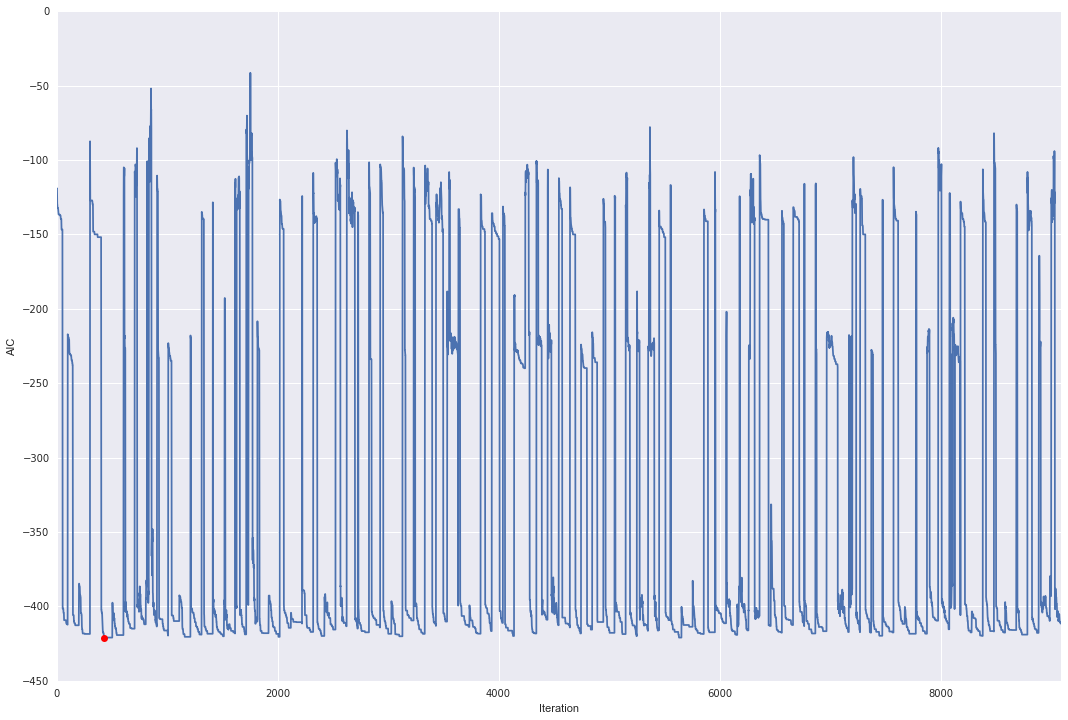

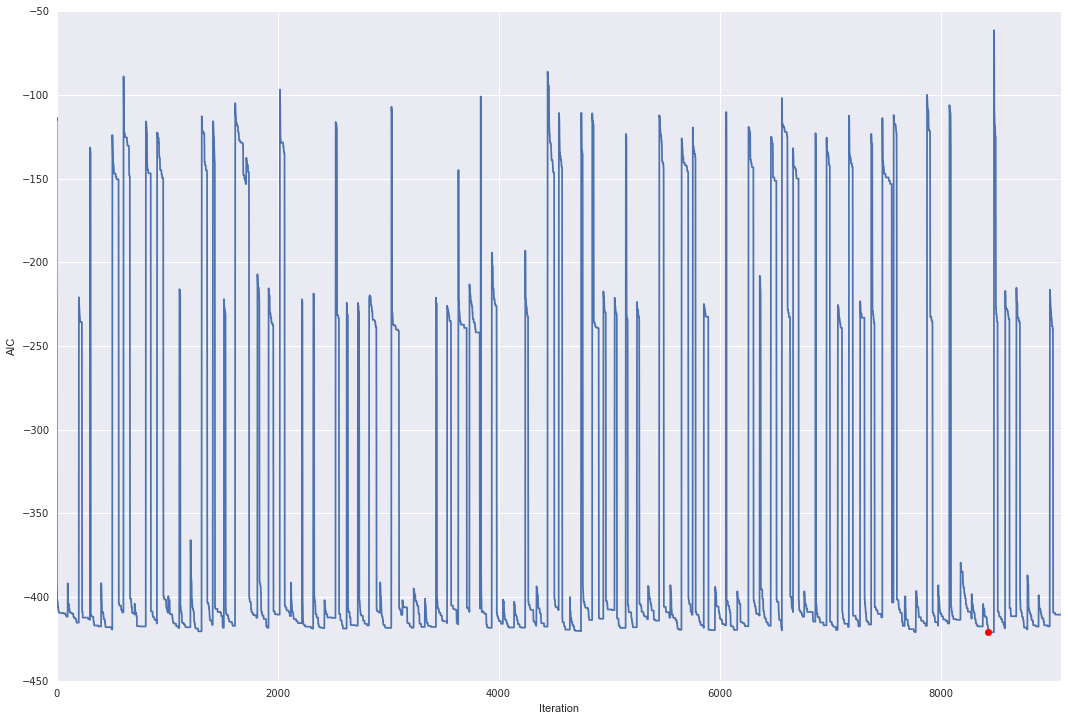

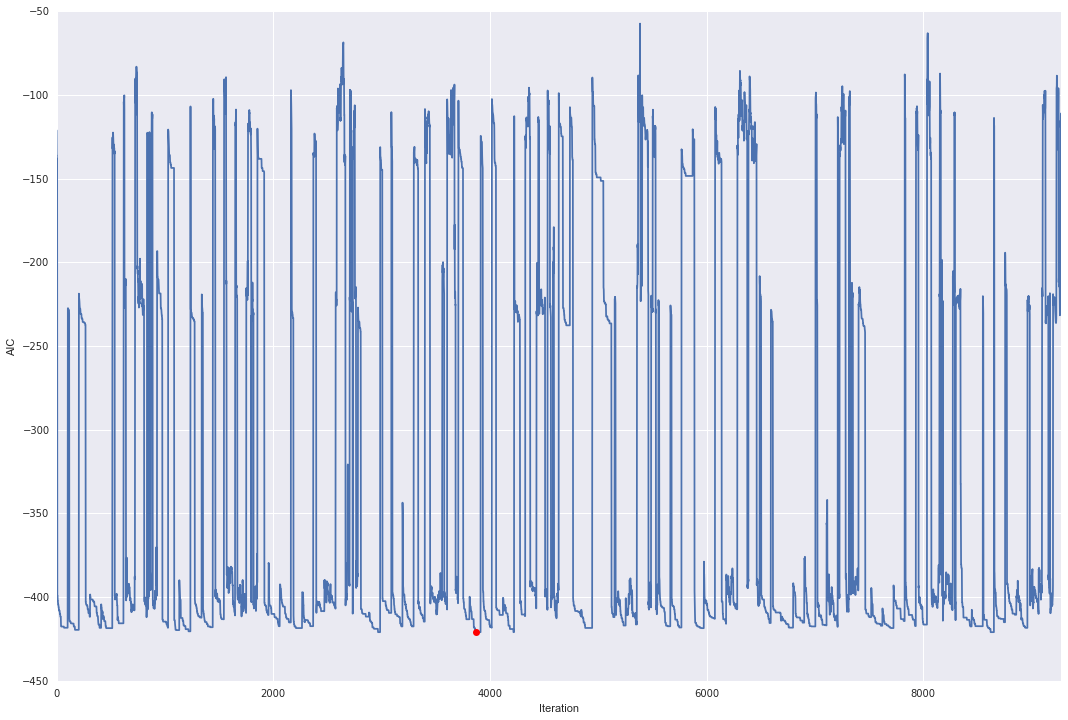

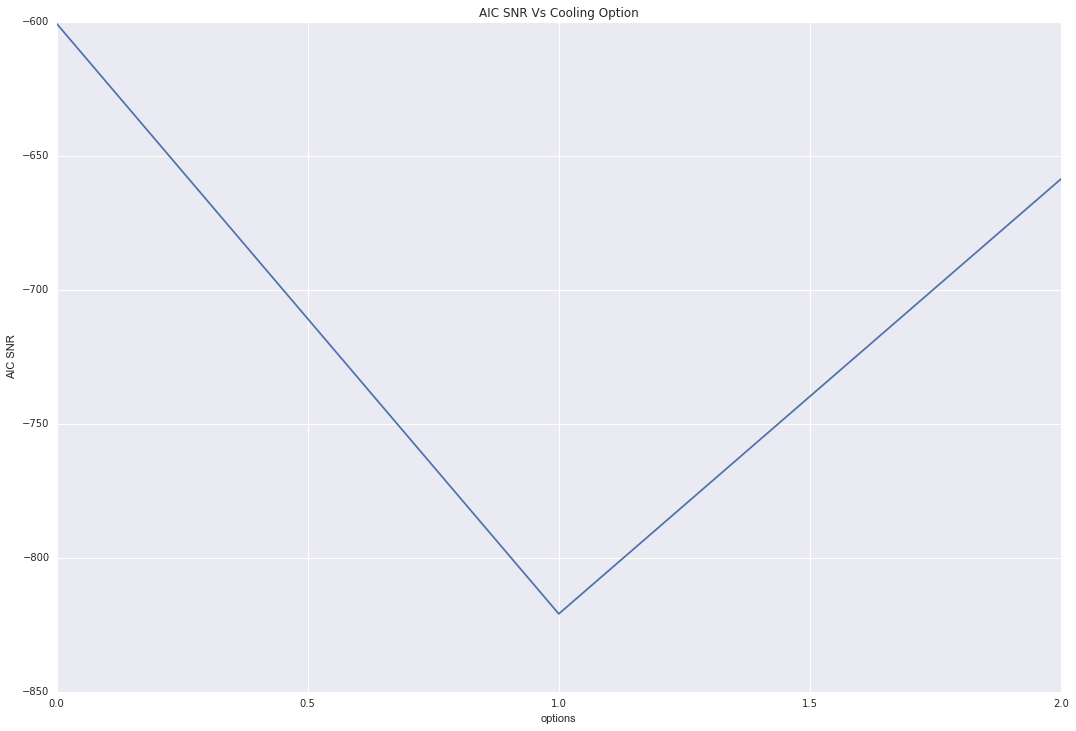

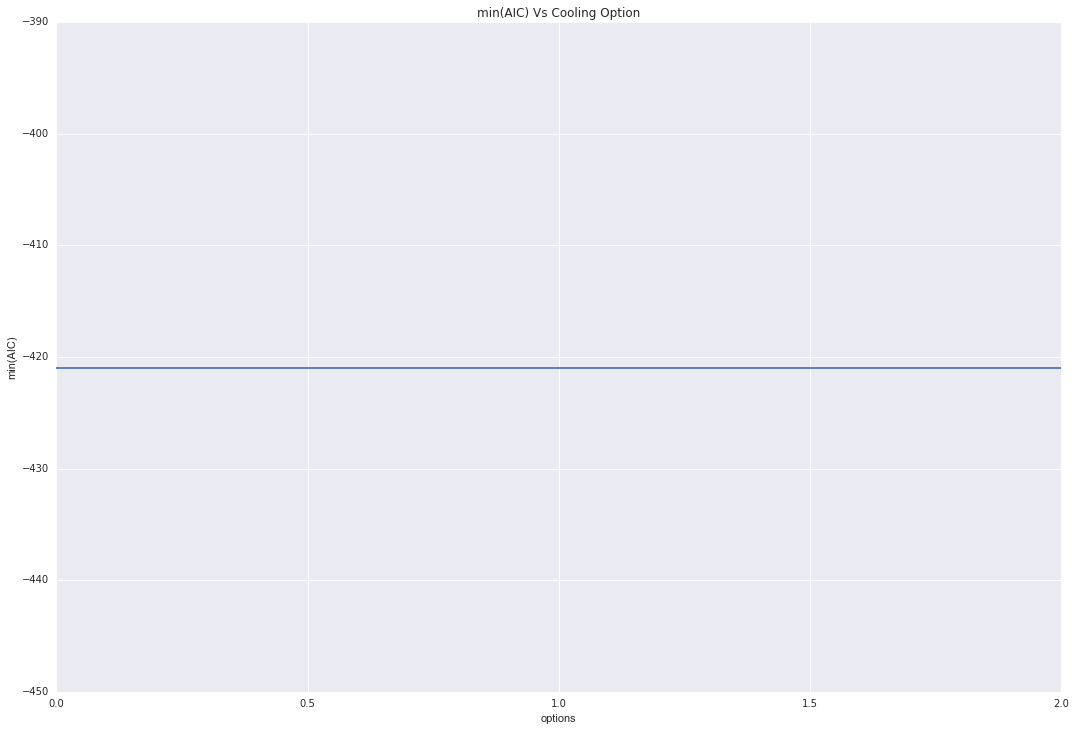

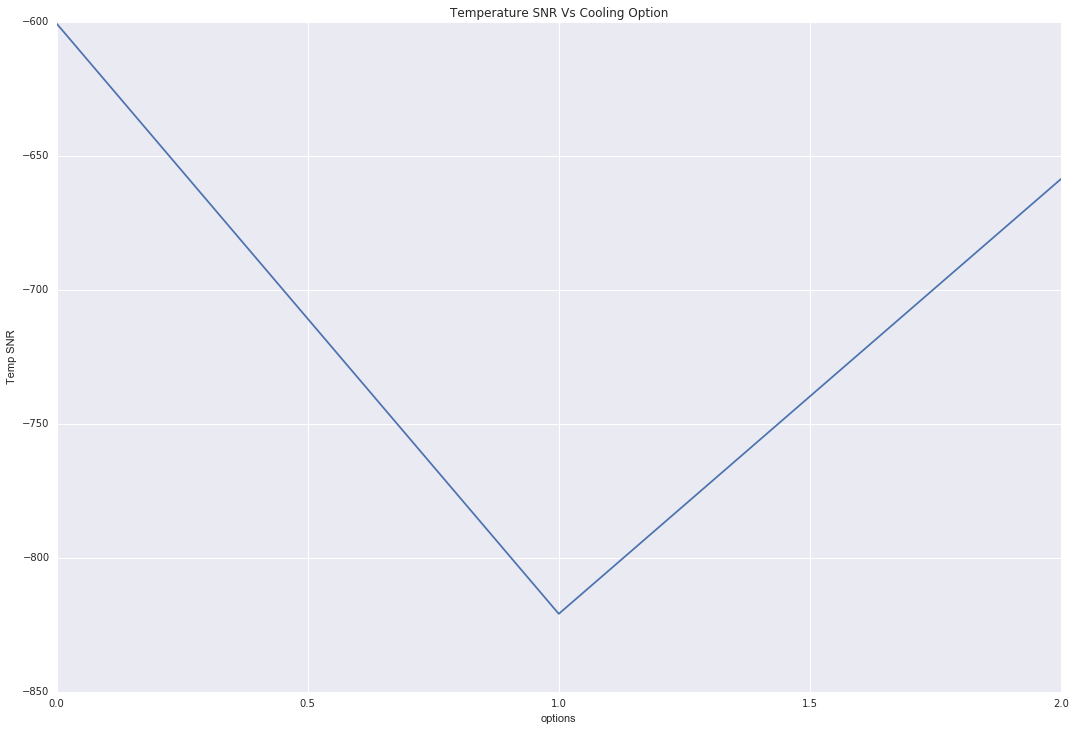

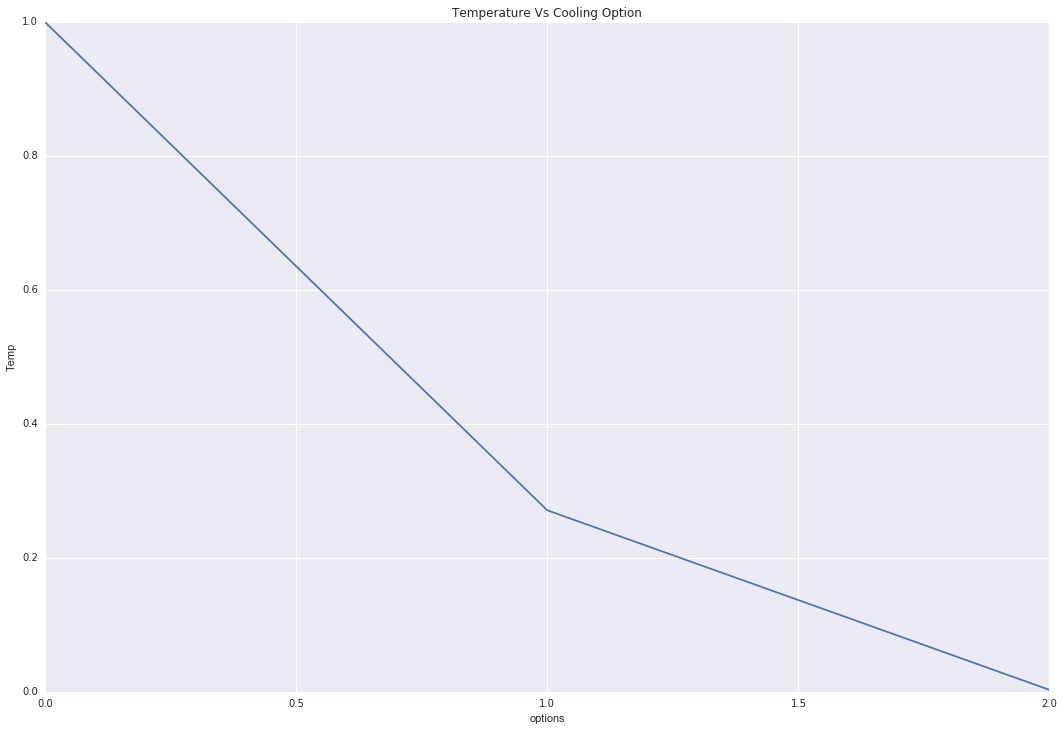

In [19]:
#2.1.a
#Varying tau while running a fast exponential decay cooling schedule
neighborhood=1
size=100
tau_start= [0.0001,.001,.01,.1,1,10,100,1000,10000]
aic_values = []
aic_best = []
solution_best_tot = []
tau_0 = -1
AICt_best = 10000000000000
AIC_best_tot = []
tau_tot = []
iterator = 10

option = 0

[AIC_m1, AIC_sd1, AIC_min1, tau_m1, tau_sd1] = test_for_temp(option,iterator,tau_start,size,neighborhood)
AIC1_SNR = np.absolute(AIC_m1/AIC_sd1)
tau1_SNR = tau_m1/tau_sd1

#Varying tau while running a exponential decay cooling schedule where slightly more time is spent earlier in the 
#sequence to explore the phase space.
aic_values = []
aic_best = []
AICt_best = 10000000000000
option = 1
[AIC_m2, AIC_sd2, AIC_min2, tau_m2, tau_sd2] = test_for_temp(option,iterator,tau_start,size,neighborhood)
AIC2_SNR = np.absolute(AIC_m2/AIC_sd2)
tau2_SNR = tau_m2/tau_sd2

#Varying tau while running a step function cooling schedule.
aic_values = []
aic_best = []
AICt_best = 10000000000000
option = 2
[AIC_m3, AIC_sd3, AIC_min3, tau_m3, tau_sd3] = test_for_temp(option,iterator,tau_start,size,neighborhood)

AIC3_SNR = np.absolute(AIC_m3/AIC_sd3)
tau3_SNR = tau_m3/tau_sd3

AIC_SNR = np.array([AIC1_SNR, AIC2_SNR, AIC3_SNR])
tau_SNR = np.array([tau1_SNR, tau2_SNR, tau3_SNR])

minAICs = [AIC_min1, AIC_min2, AIC_min3]
taus = np.array([tau_m1,tau_m2,tau_m3])
options = np.array([0,1,2])

for i,j,k in zip([AIC_SNR,minAICs,tau_SNR,taus],
                 ['AIC SNR','min(AIC)','Temp SNR','Temp'],
                 ['AIC SNR Vs Cooling Option','min(AIC) Vs Cooling Option',
                  'Temperature SNR Vs Cooling Option','Temperature Vs Cooling Option']):
    fig = plt.figure(figsize=(18, 12), dpi=100)
    plt.plot(options, i)
    plt.xlabel('options')
    plt.ylabel(j)
    plt.title(k)

#Warning: This code takes a few minutes (roughly 2min). Maybe get a drink or look up your email while wating. 

### Discussion for problem 2.1b:

I decided to take a an average and standard deviation of the "AIC Best" values across 20 different simulated 
annealing runs. It can be seen that the simulated annealing algorithm for this generation function tends to decrease 
its efficiency in finding a minimum AIC when searching in a neighborhood greater than two. In other words for 
neighborhoods > 2, the min(AIC) is greater than when the neghborhood = 1 or 2.  Also note there seems to be only 
a marginal gain in minimizing the AIC by expanding the neighborhood from 1 to 2. 

min AIC (mean, sd): -417.8165558748518 (1.508245229317147)
min AIC across simulations: -418.6118886471736
                 Best solution: (array([ 2,  5,  7,  9, 11, 12, 13, 19, 20, 21]),)
Discovered at iteration 110
min AIC (mean, sd): -418.2899615031888 (1.3656880258846125)
min AIC across simulations: -420.9472114371549
                 Best solution: (array([ 0,  2,  7,  9, 12, 13, 14, 15, 23, 24, 25]),)
Discovered at iteration 6620
min AIC (mean, sd): -417.28943271392956 (1.3812365406236353)
min AIC across simulations: -419.51844205820873
                 Best solution: (array([ 1,  2,  6,  7,  9, 12, 13, 14, 15, 16, 23, 24, 25]),)
Discovered at iteration 11166
min AIC (mean, sd): -415.2422218675053 (1.4343412982087012)
min AIC across simulations: -418.10537662728296
                 Best solution: (array([ 0,  2,  7,  9, 10, 12, 13, 14, 15, 18, 20, 23, 24, 25]),)
Discovered at iteration 15593
min AIC (mean, sd): -412.0493588017339 (2.1853792296316583)
min AIC across simulations: -

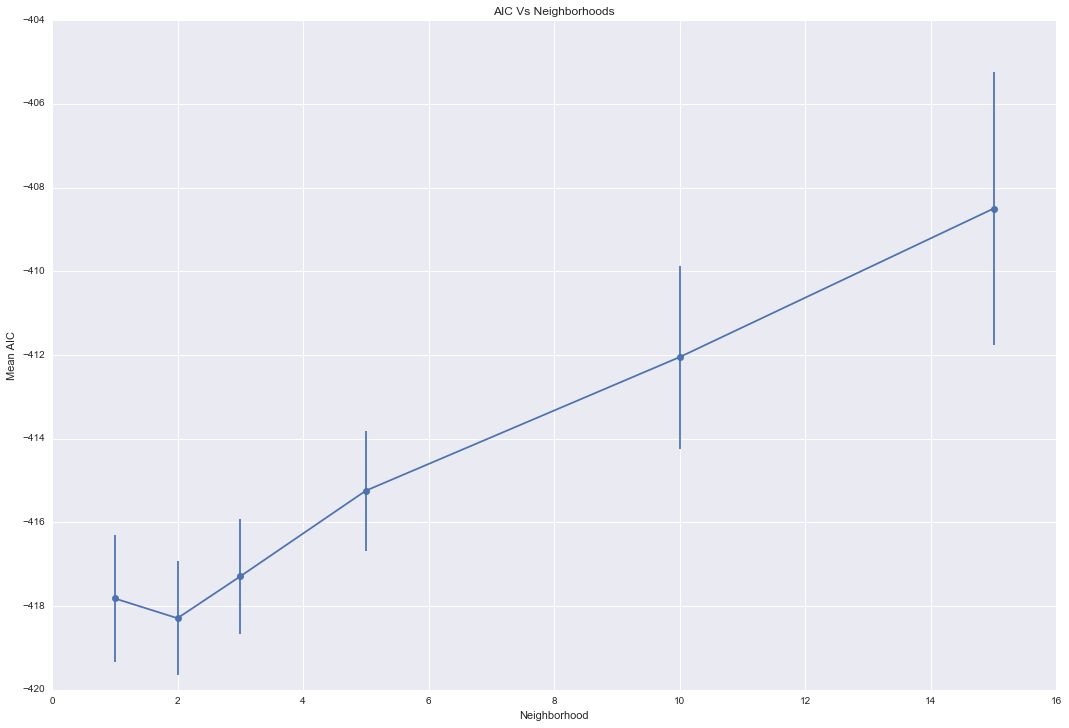

In [539]:
#2.1.b

neighborhood=1
option=1
size=200
tau_start= 2
aic_values = []
aic_best = []
solution_best_tot = []
tau_0 = -1
AICt_best = 10000000000000
AIC_best_tot = []
tau_tot = []
iterator = 20
AIC_Means = np.array([])
AIC_SD  = np.array([])
Nhoods = np.array([])

for neighborhood in [1,2,3,5,10,15]:
    [mean, sd, min] = test_for_hood(option,iterator,tau_start,size,neighborhood)
    AIC_Means = np.append(AIC_Means,mean)
    AIC_SD = np.append(AIC_SD,sd)
    Nhoods = np.append(Nhoods ,min)
    
[mean1, sd1, min1] = test_for_hood(option,iterator,tau_start,size,neighborhood)

fig = plt.figure(figsize=(18, 12), dpi=100)
plt.errorbar(Nhoods,AIC_Means,yerr= AIC_SD, fmt='-o')
plt.xlabel('Neighborhood')
plt.ylabel('Mean AIC')
plt.title('AIC Vs Neighborhoods')

In [540]:
#2.2.a) Genetic Algorithm has been written to support variable inputs for mutation rates and generation size 
#(i.e. pop_size) pop_size is the generation size.
#My discussion is in the comments below.
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

def genetic_evolve(ncols,mutation_rate=0.02,pop_size=20,iterations=100,y=logsalary):
    
  
    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    
    for i in range(iterations):
    
        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])
    
        #Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)
    
        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly
        dads = np.random.choice(range(pop_size), size=int(pop_size/2))
    
    
        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]
        
        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)

    return [aic_best,aic_history]

### Discussion for problem 2.2a:

It can be seen from the figure below that the mutation rate does aid in minimzing the AIC but that if the mutation 
rate exceeds a critical rate the benefit of mutation diminishes and tends towards increasing the noise of the 
simulations output. In other words the AIC value we are trying to minimize in this case tends to have the lowest 
value when the mutation rate is 0.01. But as the mutation rate exceeds this value the simulated values tend to 
randomly vary to a greater extent. See the figure below for further details. Outside of this value of m = 0.01 there  
is either to little variation with the "gene pool" to arrive at better "children" (i.e. the algorithm is stuck in a 
local optimum) or the mutation rate is far too high leading to high a probablitly of having a deficient mutated
"child" that leads to diminshing and worsening returns.

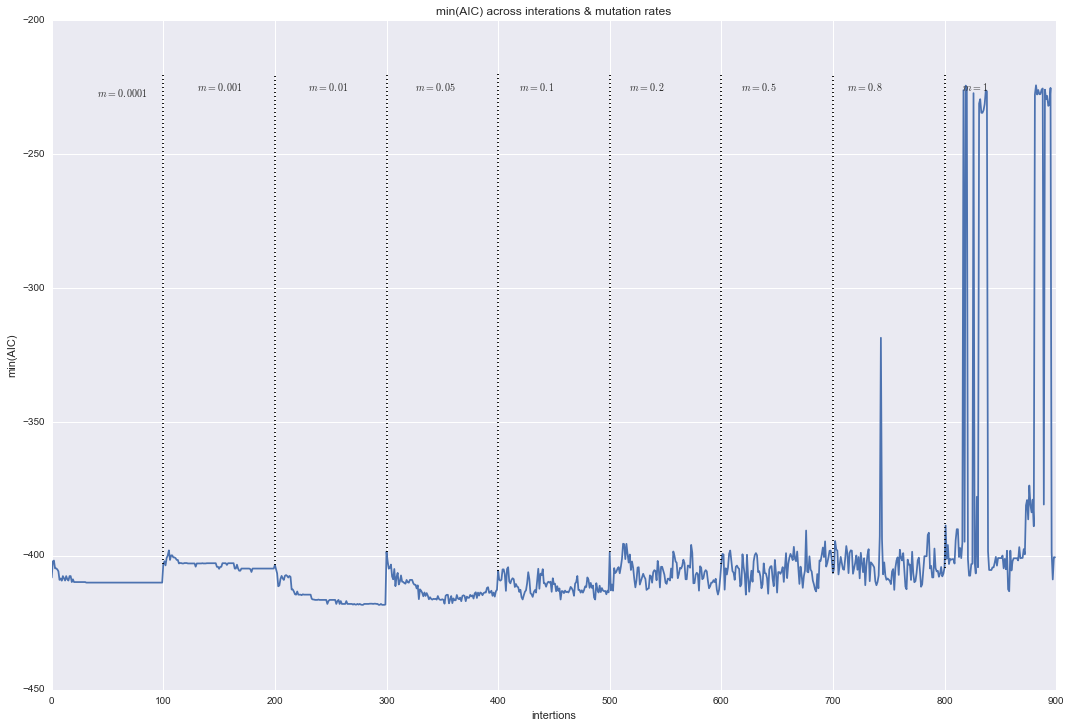

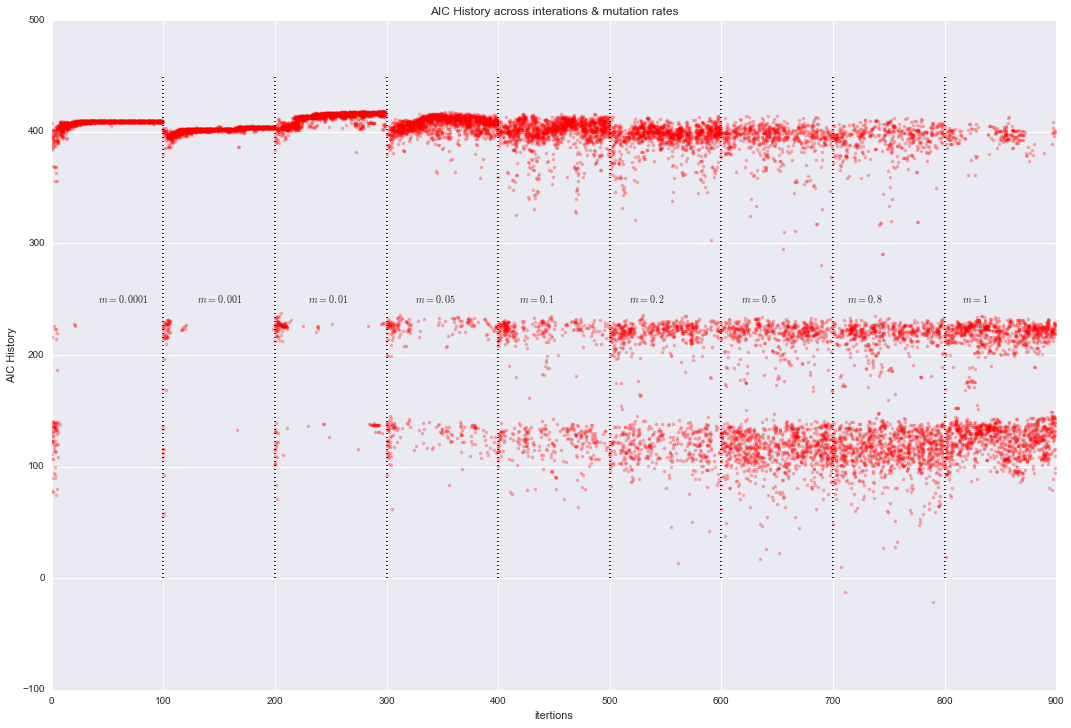

In [541]:
#2.2.a) The Genetic Algortihm is ran with constant generation size, iteration, while varying the mutation rate 
#My discussion is in the comments below.

mutation_rate= [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1]
pop_size=20
iterations=100

 
aic_best = []
best_solution = []
aic_history = []
AICm_History = []
AICm_best = []

solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
solution_vars = predictors[predictors.columns[solution_current]]
g = LinearRegression().fit(X=solution_vars, y=logsalary)

for i in mutation_rate:
    [AICm_best,AICm_history] = genetic_evolve(ncols,i,pop_size,iterations)

#2.a) continued 
#plot of aic_best each 100 interations are runs of genetic_evolve
#for the following mutation rates = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1]

fig = plt.figure(figsize=(18, 12), dpi=100)

plt.plot(AICm_best)

for j in range(0,8):
    plt.plot([(j+1)*iterations,(j+1)*iterations], [0,450], 'k:')
    plt.plot([(j+1)*iterations,(j+1)*iterations], [AICm_best[(j+1)*iterations],0.98*np.max(AICm_best)], 'k:')

for k,l in zip([1,3,5,7,9,11,13,15,17],
               ['$m=0.0001$','$m=0.001$','$m=0.01$','$m=0.05$','$m=0.1$','$m=0.2$','$m=0.5$','$m=0.8$','$m=1$']):
    plt.text(k*0.82*iterations/2, -1.01*np.max(AICm_best), l, fontsize=10)
    
plt.title('min(AIC) across interations & mutation rates')
plt.ylabel('min(AIC)')
plt.xlabel('intertions')

#2.2.a) continued
fig = plt.figure(figsize=(18, 12), dpi=100)

for i,x in enumerate(AICm_history):
    plt.plot(np.ones(len(x))*i, -x, 'r.', alpha=0.3)

for j in range(0,8):
    plt.plot([(j+1)*iterations,(j+1)*iterations], [-450,-200], 'k:')
    
for k,l in zip([1,3,5,7,9,11,13,15,17],
               ['$m=0.0001$','$m=0.001$','$m=0.01$','$m=0.05$','$m=0.1$','$m=0.2$','$m=0.5$','$m=0.8$','$m=1$']):
    plt.text(k*0.82*iterations/2, -1.1*np.max(AICm_best), l, fontsize=10)

plt.title('AIC History across interations & mutation rates')
plt.ylabel('AIC History')
plt.xlabel('itertions')

### Discussion for problem 2.2b:

It is clear from this simulation that the min(AIC) is lowered by increasing the generation size. However from my 
experience there is a diminishing return in terms of time spent on the simulation. This point of diminishing return
seems to be reached at about 50 < g < 100.

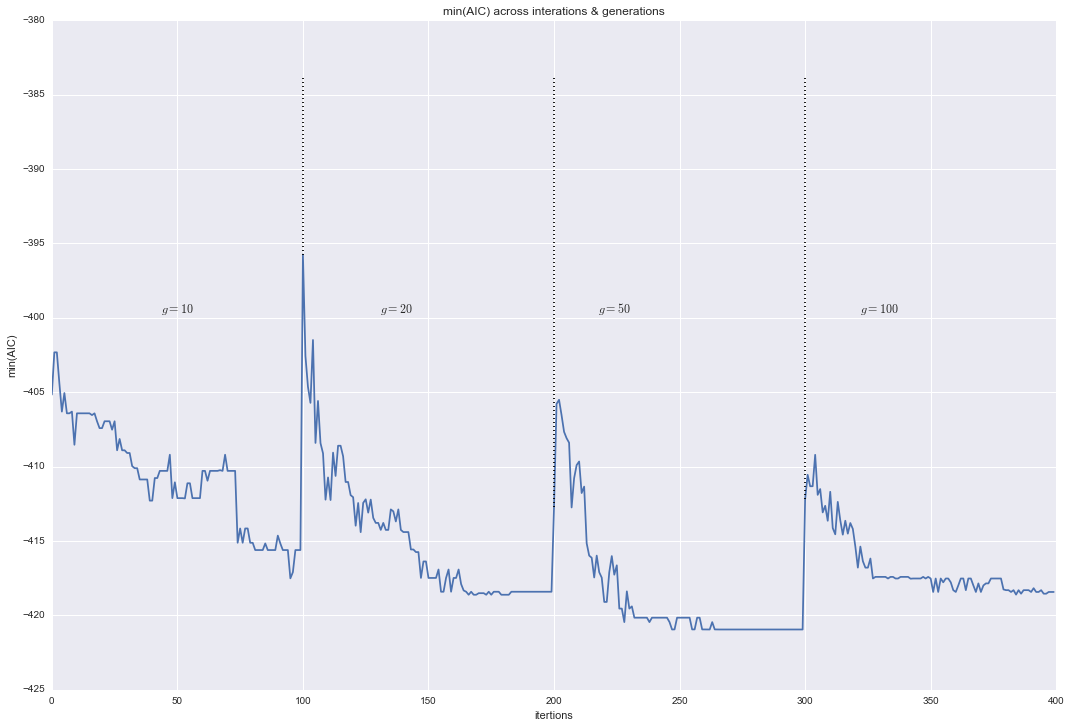

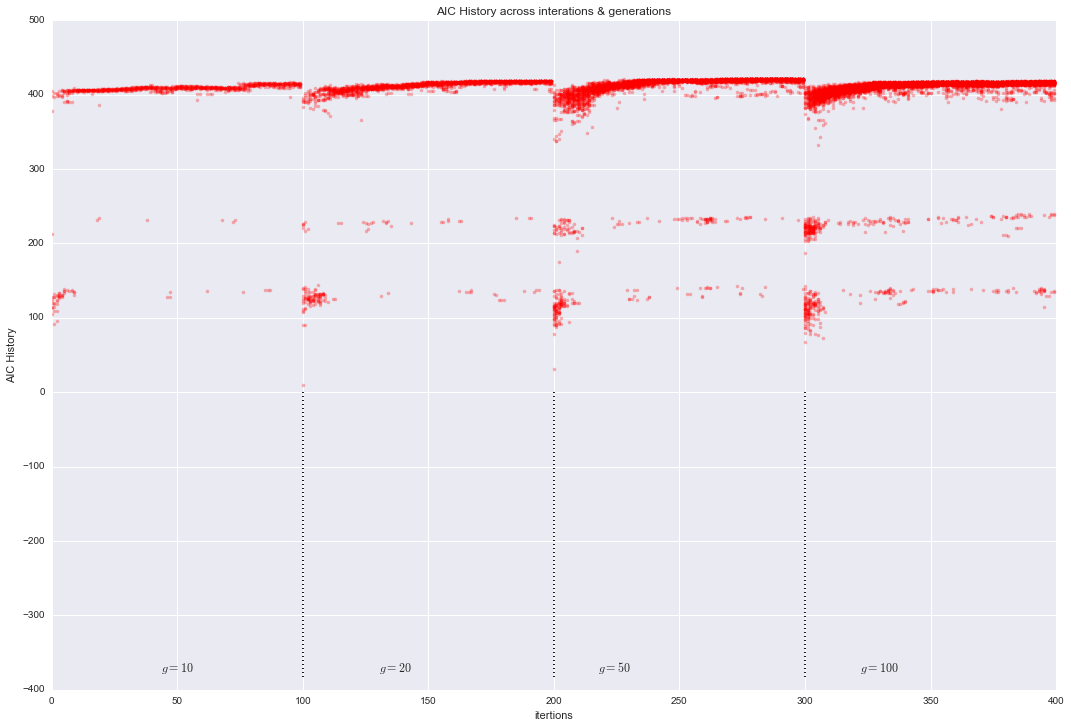

In [543]:
#2.2.b) In this code I vary the generation size. My discussion is in the comments below.
mutation_rate= 0.01
gen_size=[10,20,50,100]
iterations=100

pop_size=[]
aic_best = []
best_solution = []
aic_history = []
AICm_History = []
AICm_best = []

solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
solution_vars = predictors[predictors.columns[solution_current]]
g = LinearRegression().fit(X=solution_vars, y=logsalary)

for i in gen_size:
   
    [AICg_best,AICg_history] = genetic_evolve(ncols,mutation_rate,i,iterations)

fig = plt.figure(figsize=(18, 12), dpi=100)
plt.plot(AICg_best) 

for i in range(0,3):
    plt.plot([(i+1)*iterations,(i+1)*iterations], [AICg_best[(i+1)*iterations],0.97*np.max(AICg_best)], 'k:')

for j,k in zip([1,3,5,7],['$g=10$','$g=20$','$g=50$','$g=100$']):
    plt.text((j)*0.87*iterations/2, 1.01*np.max(AICg_best), k, fontsize=12)
    
plt.title('min(AIC) across interations & generations')
plt.ylabel('min(AIC)')
plt.xlabel('itertions')

#2.2.b)
fig = plt.figure(figsize=(18, 12), dpi=100)

for i,x in enumerate(AICg_history):
    plt.plot(np.ones(len(x))*i, -x, 'r.', alpha=0.3)
    
for i in range(0,3):
    plt.plot([(i+1)*iterations,(i+1)*iterations],  [0,0.97*np.max(AICg_best)], 'k:')

for j,k in zip([1,3,5,7],['$g=10$','$g=20$','$g=50$','$g=100$']):
    plt.text((j)*0.87*iterations/2, 0.95*np.max(AICg_best), k, fontsize=12)

plt.title('AIC History across interations & generations')
plt.ylabel('AIC History')
plt.xlabel('itertions')

### Discussion for problem 2c:

It seems that by forcing both parents to be fit that this diminishes the effects of the mutation rate and forces the 
algorithm into a local optimum. So we find a solution of fit children but these children are not the fittest as 
observed in the previous parts a and b where the parents were set to be one fit and one "unfit" for the same mutation 
rate and generation size. As can be seen in the figure below we only arive at values of roughly -418. The second 
figure shows that the diversity of the polulation is noticebly reduced as compared to similar mutation rates and 
generation sizes with the orginal combination of one unfit and one fit parent. So a lack of sufficient diversity seems 
to be the cause of not arriving at the previously found values of -420.94.

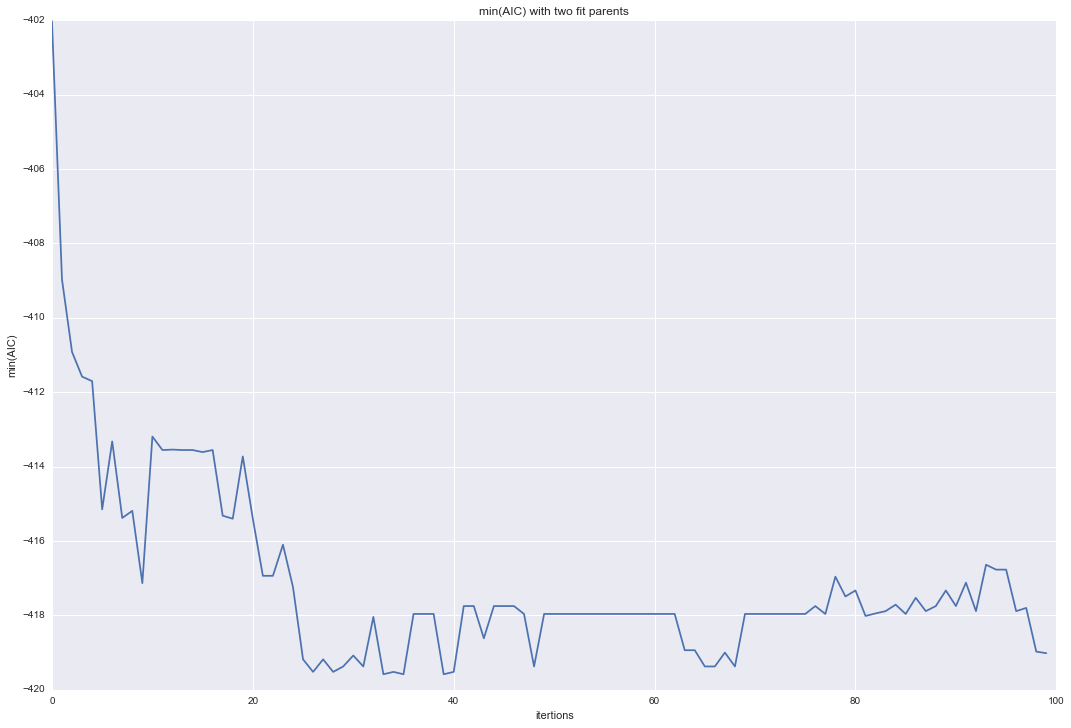

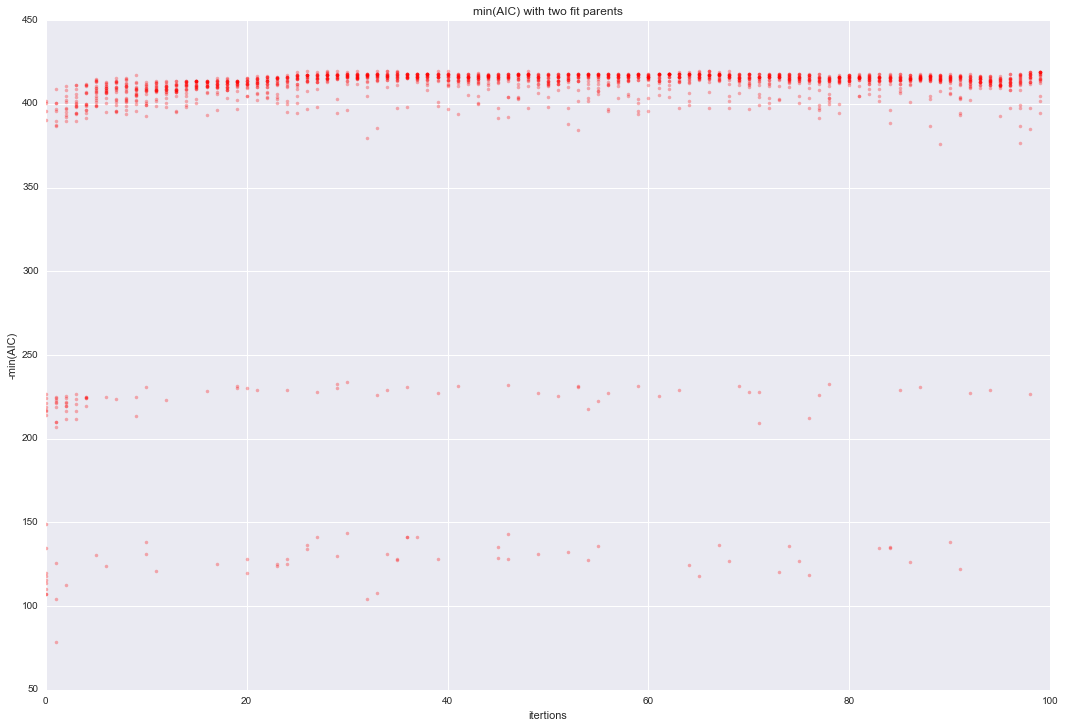

In [544]:
#2.c) Genetic Algorithm has been written to support variable inputs for mutation rates and generation size (i.e. pop_size)
#pop_size is the generation size
#My discussion is in the comments below.

def genetic_evolve_fit(ncols,mutation_rate=0.02,pop_size=20,iterations=100,y=logsalary):
    
  
    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    #aic_best = []
    #best_solution = []
    #aic_history = []
    
    for i in range(iterations):
    
        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])
    
        #Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)
    
        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly
        dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        
    
    
        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]
        
        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)

    return [aic_best,aic_history]

#2.2.c

mutation_rate= 0.05
pop_size= 20
iterations=100

AIC_mutation = [] 
aic_best = []
best_solution = []
aic_history = []

solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
solution_vars = predictors[predictors.columns[solution_current]]
g = LinearRegression().fit(X=solution_vars, y=logsalary)

[AICf_best,AICf_history] = genetic_evolve_fit(ncols,mutation_rate,pop_size,iterations)

fig = plt.figure(figsize=(18, 12), dpi=100)
plt.plot(AICf_best)
plt.title('min(AIC) with two fit parents')
plt.ylabel('min(AIC)')
plt.xlabel('itertions')

#2.2.c)
fig = plt.figure(figsize=(18, 12), dpi=100)
for i,x in enumerate(AICf_history):
    plt.plot(np.ones(len(x))*i, -x, 'r.', alpha=0.3)
    
plt.title('min(AIC) with two fit parents')
plt.ylabel('-min(AIC)')
plt.xlabel('itertions')

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). I will award 5 bonus points to the best solution!

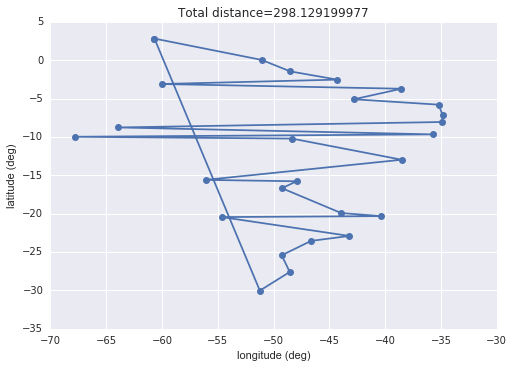

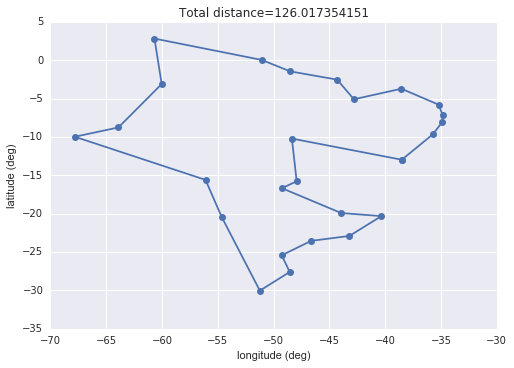

tau=   0.00010 , distance =  126.01735 , accepted steps= 42


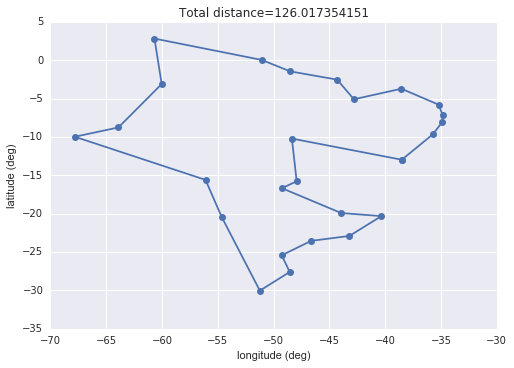

tau=   0.00010 , distance =  126.01735 , accepted steps= 0


minimum distance =  126.01735

real minimum distance =  131.60572


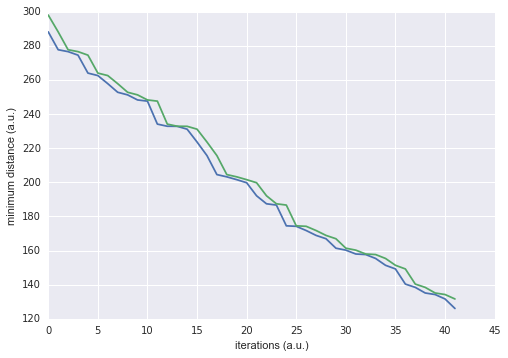

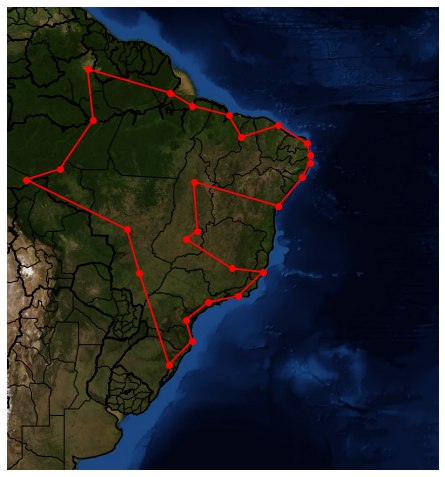

In [18]:
# This is simulated annealing algrorithm meant to solve the travelnig salesmen problem.

def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

def Distance(R1, R2):
    return np.sqrt((R1[0]-R2[0])**2+(R1[1]-R2[1])**2)


def TotalDistance(city, coordinate):
    dist=0
    for i in range(len(city)-1):
        dist += Distance(coordinate[city[i]],coordinate[city[i+1]])
    dist += Distance(coordinate[city[-1]],coordinate[city[0]])
    return dist


def Map(city, coordinate, dist):
    # Plot
    #import pdb; ;pdb.set_trace()
    Pt = [coordinate[city[i]] for i in range(len(city))] 
    Pt += [coordinate[city[0]]]
    Pt = np.array(Pt)
    plt.title('Total distance='+str(dist))
    plt.plot(-Pt[:,0], Pt[:,1], '-o')
    plt.xlabel('longitude (deg)')
    plt.ylabel('latitude (deg)')
    plt.show()
    
    return Pt


def bmap(city, coordinate, dist):
    
    xmin, xmax, ymin, ymax = -70.0, -20.0, -40.0, 10.0
    fig = plt.figure(figsize=(11.7,8.3))
    bm = Basemap(projection='merc', \
             llcrnrlon=xmin, llcrnrlat=ymin, \
             urcrnrlon=xmax, urcrnrlat=ymax, \
             lon_0=0.5*(xmax + xmin), lat_0=0.5*(ymax + ymin), \
             resolution='l', area_thresh=1000000)
    
    bm.drawcoastlines(linewidth=1.5)
    bm.bluemarble()
    bm.drawcountries(linewidth=2)
    bm.drawstates(linewidth=1)

    Pt = [coordinate[city[i]] for i in range(len(city))] 
    Pt += [coordinate[city[0]]]
    Pt = np.array(Pt)
    bm.plot(-Pt[:,0], Pt[:,1], '-ro', latlon=True)
    

def reverse(city, n):
    nct = len(city)
    nn = int((1+ ((n[1]-n[0]) % nct))/2) # half the lenght of the segment to be reversed
    # the segment is reversed in the following way n[0]<->n[1], n[0]+1<->n[1]-1, n[0]+2<->n[1]-2,...
    # Start at the ends of the segment and swap pairs of cities, moving towards the center.
    for j in range(nn):
        k = int((n[0]+j) % nct)
        l = int((n[1]-j) % nct)
        (city[k],city[l]) = (city[l],city[k])  # swap
    
    
def transpt(city, n):
    nct = len(city)
    
    newcity=[]
    # Segment in the range n[0]...n[1]
    for j in range( (n[1]-n[0])%nct + 1):
        newcity.append(city[ (j+n[0])%nct ])
    # is followed by segment n[5]...n[2]
    for j in range( (n[2]-n[5])%nct + 1):
        newcity.append(city[ (j+n[5])%nct ])
    # is followed by segment n[3]...n[4]
    for j in range( (n[4]-n[3])%nct + 1):
        newcity.append(city[ (j+n[3])%nct ])
    return newcity


#Define cooling schedule function
def cooling_schedule(size,tau_start=10,option=0):
    #option 0 offers a smooth rapid exponential decay
    if option == 0:
        return [tau_start*0.9**j for j in range(0,size)]
    #option 1 offers a gradual exponential decay
    if option == 1:
        return [0.9**j/(1+tau_start*0.9**j) for j in range(0,size)]
    #option 2 is a step function
    if option == 2:
        return ([tau_start]*int(size/6) + [tau_start/2]*int(size/5) + 
                [tau_start/10]*int(size/4) + [tau_start/100]*int(7*size/17))

    
# Number of cities to visit
ncity =  cities.index.copy().size      
ID = pd.DataFrame(dict(id=list(range(ncity))))
city_data = pd.concat([cities, ID], axis =1)

dist_values = []
dist_min = []
dist_real_values = []
dist_real_min = []
dist_real_step = []
maxSteps = 10000
maxAccepted=5000

Preverse_prime = 0.5      # How often to choose reverse/transpose trial move

#Set Coordinates
coordinates = cities.values.copy()

# The index table -- the order the cities are visited.
city = city_data['id'].values

# Distance of the travel at the beginning
dist_min = dist = TotalDistance(city, coordinates)

# Stores points of a move
n = np.zeros(10, dtype=int)
nct = len(coordinates) # number of cities


Map(city, coordinates, dist) 

tau_start = 10000
size = 5000
option = 1
cool_schedule = cooling_schedule(size,tau_start,option)
   
for tau in cool_schedule:

    Preverse = Preverse_prime      # probability of reversing or transposing direction
    accepted = 0
    for i in range(maxSteps): # At each temperature, many Monte Carlo steps
            
        while True: #find two sufficiently nearest random cities 
            # Two cities n[0] and n[1] are choosen at random
            n[0] = int((nct)*sp.rand())     # select one city
            n[1] = int((nct-1)*sp.rand())   # select another city, but not the same
            if (n[1] >= n[0]): n[1] += 1   #
            if (n[1] < n[0]): (n[0],n[1]) = (n[1],n[0]) # switch order of cities, since n[0]<n[1]
            nn = int((n[0]+nct -n[1]-1) % nct)  # the number of cities is not on the segment n[0]..n[1]
            if nn>=3: break
        
        # Need one index before and one after the two cities
        # The order hence is [n2,n0,n1,n3]
        n[2] = int((n[0]-1) % nct)  # index 1 before n0 
        n[3] = int((n[1]+1) % nct)  # index 1 after n2  
        
            
        if Preverse > sp.rand(): 
            # Here we reverse a segment
            de = (Distance(coordinates[city[n[2]]],coordinates[city[n[1]]]) 
                  + Distance(coordinates[city[n[3]]],coordinates[city[n[0]]])
                  - Distance(coordinates[city[n[2]]],coordinates[city[n[0]]])
                  - Distance(coordinates[city[n[3]]],coordinates[city[n[1]]]))
      
            if de<0 or np.exp(-de/tau)>sp.rand(): # Metropolis
                accepted += 1
                dist += de
                dist_real_step = TotalDistance(city, coordinates)
                reverse(city, n)
                dist_values.append(dist)
                dist_real_values.append(dist_real_step)
                if dist < dist_min:
                    # Replace previous best with this one
                    dist_min = dist
                    dist_real_min = dist_real_step
                   
               
        else:
            # Here we transpose a segment
            nc = int((n[1]+1+ int(sp.rand()*(nn-1)))%nct)  
            n[4] = nc
            n[5] = int((nc+1) % nct)
        
            # Cost to transpose a segment
            de = (-Distance(coordinates[city[n[1]]],coordinates[city[n[3]]]) 
                  - Distance(coordinates[city[n[0]]],coordinates[city[n[2]]])
                  - Distance(coordinates[city[n[4]]],coordinates[city[n[5]]]))
            de += (Distance(coordinates[city[n[0]]],coordinates[city[n[4]]]) 
                   + Distance(coordinates[city[n[1]]],coordinates[city[n[5]]]) 
                   + Distance(coordinates[city[n[2]]],coordinates[city[n[3]]]))
            
            
            if de<0 or np.exp(-de/tau)>sp.rand(): 
                accepted += 1
                dist += de
                dist_real_step = TotalDistance(city, coordinates) 
                city = transpt(city, n)
                dist_values.append(dist)
                dist_real_values.append(dist_real_step)
                if dist < dist_min:
                    # Replace previous best with this one
                    dist_min = dist
                    dist_real_min = dist_real_step
                    
                    
        if accepted > maxAccepted: break


    Map(city, coordinates, dist)
   
    print("tau=%10.5f , distance = %10.5f , accepted steps= %d" %(tau, dist, accepted)) 
    if accepted == 0: break  
    
    
plt.plot(dist_values)       
plt.xlabel('iterations (a.u.)')
plt.ylabel('minimum distance (a.u.)')

print("\n\nminimum distance = %10.5f" %(dist_min)) 

plt.plot(dist_real_values)       
plt.xlabel('iterations (a.u.)')
plt.ylabel('minimum distance (a.u.)')

print("\nreal minimum distance = %10.5f" %(dist_real_min)) 
  
bmap(city, coordinates, dist)

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

### Discussion for problem 4:

Since the problem was vague in its decripton the daily new cases and daily total deaths,  I decided to include a all 
cases with the either "New Cases" or "Total Deaths". If there was a additional information in the variable description 
I parsed these different items into separate columns (e.g. probable, suspected and confirmed all have separate columns
for both New cases and Total Deaths). I also wrote an additional program below where I only include the values for the 
confirmed cases.

In [551]:
def get_epdata(Directory = 'place directory',location = 'Country'):
    
    filenames = glob(Directory)
    filenames.sort()
    
    Date = []
    Country = []
    Total_Deaths_Con = []
    Total_Deaths_Prob = []
    Total_Deaths_Sus = []
    New_Cases_Con = []
    New_Cases_Prob = []
    New_Cases_Sus = []
    
    ii = 0
    for fname in filenames:
        
        f = pd.read_csv(fname) 
        if location == 'Sierra Leone':
            totals = f['National']
            Descriptions = f['variable']
            state = f['date']
            date = f['date'][0]
        if location == 'Liberia':
            totals = f['National']
            Descriptions = f['Variable']
            state = f['Date']
            date = f['Date'][0]
        if location == 'Guinea':
            totals = f['Totals']
            Descriptions = f['Description']
            state = f['Date']
            date = f['Date'][0]
       
        row1 = -1
        row2 = -1
        row3 = -1
        row4 = -1
        row5 = -1
        row6 = -1
        jj = -1
        
        for d in Descriptions:
            jj += 1
            if d == 'Total death/s in confirmed cases' or d == 'Total deaths of confirmed'or d == 'death_confirmed':
                row1 = jj
            elif d == 'Total death/s in probable cases' or d == 'Total deaths of probables'or d == 'death_probable':
                row2 = jj
            elif d == 'Total death/s in suspected cases' or d == 'Total deaths of suspects'or d == 'death_suspected':
                row3 = jj
            elif d == 'New case/s (confirmed)' or d == 'New cases of confirmed'or d == 'new_confirmed':
                row4 = jj
            elif d == 'New Case/s (Probable)' or d == 'New cases of probables'or d == 'new_probable':
                row5 = jj
            elif d == 'New Case/s (Suspected)' or d == 'New cases of suspects'or d == 'new_suspected':
                row6 = jj
                
        if row1 > -1:
            total_Dcon =  totals[row1]    
        else:
            total_Dcon =  -1
            
        if row2 > -1:
            total_Dprob =  totals[row2]    
        else:
             total_Dprob =  -1  
                
        if row3 > -1:
            total_Dsus =  totals[row3]    
        else:
            total_Dsus =  -1
            
        if row4 > -1:
            new_cases_con =  totals[row4]    
        else:
            total_deaths =  -1  
            
        if row5 > -1:
            new_cases_prob = totals[row5]   
        else: 
            new_cases_prob = -1   
            
        if row6 > -1:
            new_cases_sus = totals[row6]   
        else: 
            new_cases_sus = -1
                
        Date.append(date)
        Total_Deaths_Con.append(total_Dcon)
        Total_Deaths_Prob.append(total_Dprob)
        Total_Deaths_Sus.append(total_Dsus)
        New_Cases_Con.append(new_cases_con)
        New_Cases_Prob.append(new_cases_prob)
        New_Cases_Sus.append(new_cases_sus)
        Country.append(location)
        
    data = (pd.DataFrame({'Date': pd.to_datetime(Date),
                    'New Cases (Confirmed)': New_Cases_Con,
                    'New Cases (Probable)': New_Cases_Prob,
                    'New Cases (Suspected)': New_Cases_Sus,
                    'Total Deaths (Confirmed)': Total_Deaths_Con,
                    'Total Deaths (Probable)': Total_Deaths_Prob,
                    'Total Deaths (Suspected)': Total_Deaths_Sus
                    ,'Country': Country}))
    return data

def main():
    dir()
    
    dir_sl = '../data/ebola/sl_data/*.csv'
    dir_lib ='../data/ebola/liberia_data/*.csv'
    dir_guin = '../data/ebola/guinea_data/*.csv'

    Liberia = get_epdata(dir_lib,'Liberia')
    Guinea = get_epdata(dir_guin,'Guinea')
    SL = get_epdata(dir_sl,'Sierra Leone')
    LibGu = pd.merge(Liberia, SL,how='outer')
    LibGuSl = pd.merge( Guinea,LibGu, how='outer')
    Ebola_Data = LibGuSl.set_index(['Country', 'Date'])
   
    return Ebola_Data
  
try:
    
    Outbreak_Date_2014 =  main()
    
except  KeyboardInterrupt:
    print('goodbye cruel world')


Outbreak_Date_2014

New Cases (Confirmed) New Cases (Probable)  \
Country      Date                                                    
Guinea       2014-08-04                     4                    0   
             2014-08-26                    10                  NaN   
             2014-08-27                    10                    0   
             2014-08-30                     9                    0   
             2014-08-31                    29                    8   
             2014-09-02                    14                    0   
             2014-09-04                    17                    0   
             2014-09-07                    11                    0   
             2014-09-08                    11                    0   
             2014-09-09                     7                    0   
             2014-09-11                    13                    0   
             2014-09-14                    14                   11   
             2014-09-16                     6                    0   
             2014-09-17                     6                    0   
             2014-09-19                    12                    1   
             2014-09-21                    17                    0   
             2014-09-22                    14                    0   
             2014-09-23                    25                    0   
             2014-09-24                    20                    0   
             2014-09-26                    10                    7   
             2014-09-30                    11                    0   
             2014-10-01                     6                    0   
Liberia      2014-06-16                     1                    1   
             2014-06-17                     0                    0   
             2014-06-22                     5                    0   
             2014-06-24                     4                    0   
             2014-06-25                     2                    1   
             2014-06-28                     1                    6   
             2014-06-29                     2                    0   
             2014-07-01                     2                    0   
...                                       ...                  ...   
Sierra Leone 2014-10-27                    91                    5   
             2014-10-28                    47                    0   
             2014-10-30                    50                    0   
             2014-10-31                    95                    0   
             2014-11-01                    60                    0   
             2014-11-02                    61                    0   
             2014-11-06                    41                    0   
             2014-11-07                    45                    0   
             2014-11-08                   111                    0   
             2014-11-10                    94                    0   
             2014-11-12                    61                    0   
             2014-11-13                    84                  NaN   
             2014-11-14                   NaN                  NaN   
             2014-11-15                    54                  NaN   
             2014-11-16                    89                  NaN   
             2014-11-17                    53                  NaN   
             2014-11-18                    43                  NaN   
             2014-11-19                   NaN                  NaN   
             2014-11-20                    94                    0   
             2014-11-21                    51                    0   
             2014-11-22                    47                    0   
             2014-11-23                    39                    0   
             2014-11-24                    83                    0   
             2014-11-28                    84                    0   
             2014-11-29           

### Alternate Solution to problem 4. In this code I only return the confirmed New Cases and Total deaths.

In [552]:
def get_sl_data():
    
    filenames = glob('../data/ebola/sl_data/*.csv')
    filenames.sort()
    
    Date = []
    Total_Deaths = []
    New_Cases = []
    Country = []
    
    ii = 0
    for fname in filenames:
        f = pd.read_csv(fname) 
        totals = f['National']
        Descriptions = f['variable']
        state = f['date']
        date = f['date'][0]
        row1 = -1
        row2 = -1
        jj = -1
       
        
        for d in Descriptions:
            jj += 1
            
            
            if d == 'death_confirmed':
                row1 = jj
            elif d == 'new_confirmed':
                row2 = jj
            
        if row1 > -1:
            total_deaths =  totals[row1]
            
            
        else:
            total_deaths =  -1
        if row2 > -1:
            new_cases = totals[row2]
            
           
        else: 
            new_cases = -1
                
        Date.append(date)
        Total_Deaths.append(total_deaths)
        New_Cases.append(new_cases)
        Country.append('Sierra Leone')
        
        
    data = (pd.DataFrame({'Date': pd.to_datetime(Date),
                    'New Cases': New_Cases,
                    'Total Deaths': Total_Deaths,'Country': Country}))

    return data


def get_liberia_data():
    
    filenames = glob('../data/ebola/liberia_data/*.csv')
    filenames.sort()
       
    Date = []
    Total_Deaths = []
    New_Cases = []
    Country = []
    
    ii = 0
    for fname in filenames:
        f = pd.read_csv(fname) 
        totals = f['National']
        Descriptions = f['Variable']
        date = f['Date'][0]
        row1 = -1
        row2 = -1
        jj = -1
        
        for d in Descriptions:
            jj += 1
            if d == 'Total death/s in confirmed cases':
                row1 = jj
            elif d == 'New case/s (confirmed)':
                row2 = jj
        
        if row1 > -1:
            total_deaths =  totals[row1]
        else:
            total_deaths =  -1
        if row2 > -1:
            new_cases = totals[row2]
        else: 
            new_cases = -1
                
        Date.append(date)
        Total_Deaths.append(total_deaths)
        New_Cases.append(new_cases)
        Country.append('Liberia')

    data = (pd.DataFrame({'Date': pd.to_datetime(Date),
                    'New Cases': New_Cases,
                    'Total Deaths': Total_Deaths, 'Country': Country}))

    return data


def get_guinea_data():
    
    filenames = glob('../data/ebola/guinea_data/*.csv')
    filenames.sort()
    
    Date = []
    Total_Deaths = []
    New_Cases = []
    Country = []
    
    ii = 0
    for fname in filenames:
        f = pd.read_csv(fname) 
        totals = f['Totals']
        Descriptions = f['Description']
        date = f['Date'][0]
        row1 = -1
        row2 = -1
        jj = -1
        
        for d in Descriptions:
            jj += 1
            if d == 'Total deaths of confirmed':
                row1 = jj
            elif d == 'New cases of confirmed':
                row2 = jj
        
        if row1 > -1:
            total_deaths =  totals[row1]
        else:
            total_deaths =  -1
        if row2 > -1:
            new_cases = totals[row2]
        else: 
            new_cases = -1
                
        #print(fname, row1, row2,date, new_cases, total_deaths)
        Date.append(date)
        Total_Deaths.append(total_deaths)
        New_Cases.append(new_cases)
        Country.append('Guinea')
    
    data = (pd.DataFrame({'Date': pd.to_datetime(Date),
                    'New Cases': New_Cases,
                    'Total Deaths': Total_Deaths, 'Country': Country}))
    
    return data
        

def main():
    dir()

    Liberia = get_liberia_data()
    Guinea = get_guinea_data()
    SL = get_sl_data()
    LibGu = pd.merge(Liberia, SL,how='outer')
    LibGuSl = pd.merge(Gu,LibGu, how='outer')
    Ebola_Data = LibGuSl.set_index(['Country', 'Date'])
    
    return Ebola_Data
  
try:
    
    Outbreak_Date_2014 =  main()
    
except  KeyboardInterrupt:
    print('goodbye cruel world')


Outbreak_Date_2014

New Cases Total Deaths
Country      Date                             
Guinea       2014-08-04         4          228
             2014-08-26        10          292
             2014-08-27        10          294
             2014-08-30         9          324
             2014-08-31        29          337
             2014-09-02        14          349
             2014-09-04        17          368
             2014-09-07        11          402
             2014-09-08        11          402
             2014-09-09         7          410
             2014-09-11        13          413
             2014-09-14        14          429
             2014-09-16         6          442
             2014-09-17         6          442
             2014-09-19        12          463
             2014-09-21        17          465
             2014-09-22        14          468
             2014-09-23        25          476
             2014-09-24        20          481
             2014-09-26        10          668
             2014-09-30        11          539
             2014-10-01         6          562
Liberia      2014-06-16         1            8
             2014-06-17         0            8
             2014-06-22         5           16
             2014-06-24         4           18
             2014-06-25         2           20
             2014-06-28         1           26
             2014-06-29         2           26
             2014-07-01         2           30
...                           ...          ...
Sierra Leone 2014-10-27        91         1049
             2014-10-28        47         1057
             2014-10-30        50         1064
             2014-10-31        95         1070
             2014-11-01        60         1077
             2014-11-02        61         1085
             2014-11-06        41         1114
             2014-11-07        45         1126
             2014-11-08       111         1133
             2014-11-10        94         1149
             2014-11-12        61         1169
             2014-11-13        84         1180
             2014-11-14       NaN          NaN
             2014-11-15        54         1206
             2014-11-16        89         1223
             2014-11-17        53         1223
             2014-11-18        43         1240
             2014-11-19       NaN          NaN
             2014-11-20        94         1282
             2014-11-21        51         1303
             2014-11-22        47         1333
             2014-11-23        39         1364
             2014-11-24        83         1397
             2014-11-28        84         1481
             2014-11-29        64         1496
             2014-12-01        72         1549
             2014-12-04        37         1648
             2014-12-05        54         1669
             2014-12-06       NaN         1708
             2014-12-13       NaN          NaN

[225 rows x 2 columns]